[![ Click here to deploy.](https://uohmivykqgnnbiouffke.supabase.co/storage/v1/object/public/landingpage/brevdeploynavy.svg)](https://console.brev.dev/launchable/deploy?launchableID=env-2p32dFTsjecDZOrOOJCok3qZuYV)

<div class=\"alert alert-block alert-info\"> <b>NOTE</b> it takes about 10 minutes to deploy this notebook as a Launchable. As of this writing, we are working on a free tier so a credit card may be required. You can reach out to your NVIDIA rep for credits. </div>

In [1]:
cleanup:bool=True

# Geneformer Cell Type Classification Benchmark
Here we benchmark four models, with two baselines. These models are tasked with cell type classification, using the Chron’s disease small intestine dataset from Elmentaite et al. (2020), Developmental Cell. This dataset contains approximately 22,500 single cells from both healthy children aged 4-13 and chidlren with Chron’s disease. This dataset contains 31 unique cell types which we assume to be annotated accurately. This dataset was held out of our pre-training dataset as all diseased samples were removed.

* Baseline (1) scRNA workflow: this model uses PCA with 10 components and random forest on normalized and log transformed expression counts to produce a result.
* Baseline (2) geneformer with random weight initialization. Some performance can come from large random projections, but we want to do better than that.
* geneformer-10M + geneformer106M as described in the model cards.

First, we download the dataset from czi that we are interested in, and then create the requisite sc_memmap dataset object.

In [2]:
#NBVAL_CHECK_OUTPUT
import cellxgene_census
CENSUS_VERSION = "2023-12-15"
with cellxgene_census.open_soma(census_version=CENSUS_VERSION) as census:
    adata = cellxgene_census.get_anndata(census, "Homo sapiens",
            obs_value_filter='dataset_id=="8e47ed12-c658-4252-b126-381df8d52a3d"',
        )
uq_cells = sorted(adata.obs['cell_type'].unique().tolist())
uq_cells

['B cell',
 'CD4-positive, alpha-beta T cell',
 'CD8-positive, alpha-beta T cell',
 'IgA plasma cell',
 'IgG plasma cell',
 'M cell of gut',
 'T follicular helper cell',
 'activated CD4-positive, alpha-beta T cell, human',
 'conventional dendritic cell',
 'dendritic cell, human',
 'endothelial cell of artery',
 'endothelial cell of lymphatic vessel',
 'enterocyte',
 'enteroendocrine cell',
 'fibroblast',
 'gamma-delta T cell',
 'glial cell',
 'intestinal crypt stem cell',
 'intestinal tuft cell',
 'intestine goblet cell',
 'mast cell',
 'memory B cell',
 'monocyte',
 'myeloid cell',
 'myofibroblast cell',
 'pericyte',
 'plasma cell',
 'plasmacytoid dendritic cell',
 'regulatory T cell',
 'transit amplifying cell',
 'vein endothelial cell']

In [3]:
#NBVAL_CHECK_OUTPUT

# Subset the anndata so this example runs faster. This step can be skipped.

import random
from contextlib import contextmanager

@contextmanager
def random_seed(seed:int):
    state = random.getstate()
    random.seed(seed)
    try:
        yield
    finally:
        # Go back to previous state
        random.setstate(state)

with random_seed(32):
    indices = list(range(len(adata)))
    random.shuffle(indices)

micro_batch_size:int = 32
num_steps:int = 255
num_samples = micro_batch_size*num_steps + 15  # show that we can now handle a partial final batch.

selection = sorted(indices[:num_samples])
adata = adata[selection].copy() # so it's not a view
adata.shape

(8175, 60664)

In [4]:
import shutil
from bionemo.core import BIONEMO_CACHE_DIR
cleanup:bool=True
notebook_workdir = BIONEMO_CACHE_DIR / "notebook_tutorials" / "geneformer_celltype_classification"
if cleanup and notebook_workdir.exists():
    shutil.rmtree(notebook_workdir)
notebook_workdir.mkdir(parents=True, exist_ok=True)
data_dir = notebook_workdir / "celltype-bench-dataset"
data_dir.mkdir(parents=True, exist_ok=True)
h5ad_outfile = data_dir / "hs-celltype-bench.h5ad"
adata.write_h5ad(h5ad_outfile)

## Create the scmemmap object, check outputs

In [5]:
!sc_memmap --data-path {data_dir} --save-path {data_dir} --obs-cols cell_type --strict-metadata

/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/usr

Importantly, the .npy files are used by BioNeMo dataset object. features.csv contains the metadata requested, in this case cell_type. It's important that the output of our model has the same order as features.csv, as this contains the labels used in the following benchmark.

In [6]:
#NBVAL_CHECK_OUTPUT
from glob import glob
files = sorted([f.split("/")[-1] for f in glob(str(data_dir/"*"))]) # strip off the directory name and sort for the test
files

['features.csv',
 'gene_expression_data.npy',
 'gene_expression_ind.npy',
 'gene_expression_ptr.npy',
 'hs-celltype-bench.h5ad',
 'metadata.json']

In [7]:
from bionemo.core.data.load import load
# 106m checkpoint
geneformer_106m = load("geneformer/106M_240530:2.0")
# 10m checkpoint
geneformer_10m = load("geneformer/10M_240530:2.0")
# 10m bionemo2 trained checkpoint
geneformer_10m_bnmo2 = load("geneformer/10M_241113:2.0")

In [8]:
result_path_10m = notebook_workdir / "results_10m.pt"
result_path_10m_bnmo2 = notebook_workdir / "results_10m_bnmo2.pt"
results_path_10m_random = notebook_workdir / "results_10m_randomweights.pt"
result_path_106m = notebook_workdir / "results_106m.pt"

## Execute inference
We run inference on all there of our models, which are downloaded by `load(...)` function in a previous cell. We have a one-off inference script for geneformer that is installed as part of the `bionemo-geneformer` package. See the `pyproject.toml` in the source directory if you are curious or want to use this as a template to make your own inference scripts. This script should work for any `sc_memmap` converted geneformer dataset, and geneformer bionemo2 model checkpoint though.

In [9]:
!infer_geneformer --data-dir {data_dir} --checkpoint-path {geneformer_10m} --result-path {result_path_10m} --micro-batch-size {micro_batch_size} --seq-len 2048  --num-dataset-workers 10

[NeMo W 2024-11-20 22:48:03 ssm:31] The package `megatron.core` was not imported in this environment which is needed for SSMs.
[NeMo W 2024-11-20 22:48:04 nemo_logging:361] /usr/local/lib/python3.10/dist-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
      warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
    
[NeMo W 2024-11-20 22:48:05 preprocess:101] Tokenizer vocab file: /home/bionemo/.cache/bionemo/db24ba3858005680e343d0e4714c7c91fde6d738e2bf4018d489c0b1541544df-singlecell-testdata-20240506.tar.gz.untar/cellxgene_2023-12-15_small/processed_data/train/geneformer.vocab already exists. Overwriting...
[NeMo I 2024-11-20 22:48:05 remote:136] No checksum provided, filename exists. Assuming it is complete.
[NeMo I 2024-11-20 22:48:05 remote:124] Resource already exists, skipping download: https://huggingface.co/ctheodoris/Geneformer/resolve/main/geneformer/gene_dictionaries

In [10]:
!infer_geneformer --data-dir {data_dir} --checkpoint-path {geneformer_10m_bnmo2} --result-path {result_path_10m_bnmo2} --micro-batch-size {micro_batch_size} --seq-len 2048  --num-dataset-workers 10

[NeMo W 2024-11-20 22:48:43 ssm:31] The package `megatron.core` was not imported in this environment which is needed for SSMs.
[NeMo W 2024-11-20 22:48:44 nemo_logging:361] /usr/local/lib/python3.10/dist-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
      warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
    
[NeMo W 2024-11-20 22:48:45 preprocess:101] Tokenizer vocab file: /home/bionemo/.cache/bionemo/db24ba3858005680e343d0e4714c7c91fde6d738e2bf4018d489c0b1541544df-singlecell-testdata-20240506.tar.gz.untar/cellxgene_2023-12-15_small/processed_data/train/geneformer.vocab already exists. Overwriting...
[NeMo I 2024-11-20 22:48:45 remote:136] No checksum provided, filename exists. Assuming it is complete.
[NeMo I 2024-11-20 22:48:45 remote:124] Resource already exists, skipping download: https://huggingface.co/ctheodoris/Geneformer/resolve/main/geneformer/gene_dictionaries

In [11]:
# NOTE: due to a an issue we are working on fixing, predict results have the last batch dropped
#  so set micro-batch-size=1 to make sure we get all results.
!infer_geneformer --data-dir {data_dir} --result-path {results_path_10m_random} --micro-batch-size {micro_batch_size} --seq-len 2048  --num-dataset-workers 10

[NeMo W 2024-11-20 22:49:22 ssm:31] The package `megatron.core` was not imported in this environment which is needed for SSMs.
[NeMo W 2024-11-20 22:49:23 nemo_logging:361] /usr/local/lib/python3.10/dist-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
      warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
    
[NeMo W 2024-11-20 22:49:24 preprocess:101] Tokenizer vocab file: /home/bionemo/.cache/bionemo/db24ba3858005680e343d0e4714c7c91fde6d738e2bf4018d489c0b1541544df-singlecell-testdata-20240506.tar.gz.untar/cellxgene_2023-12-15_small/processed_data/train/geneformer.vocab already exists. Overwriting...
[NeMo I 2024-11-20 22:49:24 remote:136] No checksum provided, filename exists. Assuming it is complete.
[NeMo I 2024-11-20 22:49:24 remote:124] Resource already exists, skipping download: https://huggingface.co/ctheodoris/Geneformer/resolve/main/geneformer/gene_dictionaries

Writing output ['embeddings'] into /home/bionemo/.cache/bionemo/notebook_tutorials/geneformer_celltype_classification/results_10m_randomweights.pt


In [12]:
!infer_geneformer --data-dir {data_dir} --checkpoint-path {geneformer_106m} --result-path {result_path_106m} --micro-batch-size {micro_batch_size} --seq-len 2048 --num-dataset-workers 10

[NeMo W 2024-11-20 22:49:58 ssm:31] The package `megatron.core` was not imported in this environment which is needed for SSMs.
[NeMo W 2024-11-20 22:49:59 nemo_logging:361] /usr/local/lib/python3.10/dist-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
      warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
    
[NeMo W 2024-11-20 22:50:00 preprocess:101] Tokenizer vocab file: /home/bionemo/.cache/bionemo/db24ba3858005680e343d0e4714c7c91fde6d738e2bf4018d489c0b1541544df-singlecell-testdata-20240506.tar.gz.untar/cellxgene_2023-12-15_small/processed_data/train/geneformer.vocab already exists. Overwriting...
[NeMo I 2024-11-20 22:50:00 remote:136] No checksum provided, filename exists. Assuming it is complete.
[NeMo I 2024-11-20 22:50:00 remote:124] Resource already exists, skipping download: https://huggingface.co/ctheodoris/Geneformer/resolve/main/geneformer/gene_dictionaries

## Benchmarking
see below the benchmarking snippet. We take in a datavector, and a set of labels. We optionally fit PCA and then a RF model inside cross validation. Metrics are using the `macro` (average over each class) for handling multi-class labels. Additionally, we return the confusion matrix for further investigation.

In [13]:
def run_benchmark(data, labels, use_pca=True):
    ''' 
    data - contains the single cell expression (or whatever feature) in each row.
    labels - contains the string label for each cell
    
    data_shape (R, C)
    labels_shape (R,)
    '''
    import numpy as np
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import StratifiedKFold, cross_validate
    from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
    from sklearn.decomposition import PCA
    from sklearn.model_selection import cross_val_predict

    np.random.seed(1337)
    # Define the target dimension 'n_components'
    n_components = 10  # for example, adjust based on your specific needs

    # Create a pipeline that includes Gaussian random projection and RandomForestClassifier
    if use_pca:
        pipeline = Pipeline([
            ('projection', PCA(n_components=n_components)),
            ('classifier', RandomForestClassifier(class_weight='balanced'))
        ])
    else:
        pipeline = Pipeline([
            ('classifier', RandomForestClassifier(class_weight='balanced'))
        ])

    # Set up StratifiedKFold to ensure each fold reflects the overall distribution of labels
    cv = StratifiedKFold(n_splits=5)

    # Define the scoring functions
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='macro'),  # 'macro' averages over classes
        'recall': make_scorer(recall_score, average='macro'),
        'f1_score': make_scorer(f1_score, average='macro'),
        # 'roc_auc' requires probability or decision function; hence use multi_class if applicable
        'roc_auc': make_scorer(roc_auc_score, multi_class='ovr', needs_proba=True),
    }

    # Perform stratified cross-validation with multiple metrics using the pipeline
    results = cross_validate(pipeline, data, labels, cv=cv, scoring=scoring, return_train_score=False)

    # Print the cross-validation results
    print("Cross-validation metrics:")
    results_out = {}
    for metric, scores in results.items():
        if metric.startswith('test_'):
            results_out[metric] = (scores.mean(), scores.std())
            print(f"{metric[5:]}: {scores.mean():.3f} (+/- {scores.std():.3f})")
    
    predictions = cross_val_predict(pipeline, data, labels, cv=cv)

    # Return confusion matrix and metrics.
    conf_matrix = confusion_matrix(labels, predictions)
    
    return results_out, conf_matrix

In [14]:
#NBVAL_CHECK_OUTPUT
import torch
infer_Xs_10m = torch.load(result_path_10m)['embeddings'].float().cpu().numpy()
assert len(adata) == len(infer_Xs_10m), (len(adata), len(infer_Xs_10m))
infer_Xs_10m.shape

(8175, 256)

In [15]:
#NBVAL_CHECK_OUTPUT
import torch
infer_Xs_10m_bnmo2 = torch.load(result_path_10m_bnmo2)['embeddings'].float().cpu().numpy()
assert len(adata) == len(infer_Xs_10m_bnmo2), (len(adata), len(infer_Xs_10m))
infer_Xs_10m_bnmo2.shape

(8175, 256)

In [16]:
#NBVAL_CHECK_OUTPUT
infer_Xs_106m = torch.load(result_path_106m)['embeddings'].float().cpu().numpy()
assert len(adata) == len(infer_Xs_106m), (len(adata), len(infer_Xs_106m))
infer_Xs_106m.shape

(8175, 768)

In [17]:
#NBVAL_CHECK_OUTPUT
import torch
infer_Xs_10m_random = torch.load(results_path_10m_random)['embeddings'].float().cpu().numpy()
assert len(adata) == len(infer_Xs_10m_random), (len(adata), len(infer_Xs_10m_random))
infer_Xs_10m_random.shape

(8175, 256)

In [18]:
import pandas as pd
import numpy as np
# Now fetch the class labels and raw expression for the same dataset. These are used as labels in classification and as one of our baselines.

infer_metadata = pd.read_csv(data_dir/'features.csv')
raw_Xs = np.asarray(adata.X.todense())
# Here we perform a norm over the total counts for each cell, adding a pseudocount to assist with the following logarithm.
normed_Xs = (raw_Xs + 1) / raw_Xs.sum(axis=1, keepdims=True)
logp1_Xs = np.log( normed_Xs )

/tmp/ipykernel_703689/2938980837.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


Text(0.5, 1.0, 'Cell type counts for classification dataset')

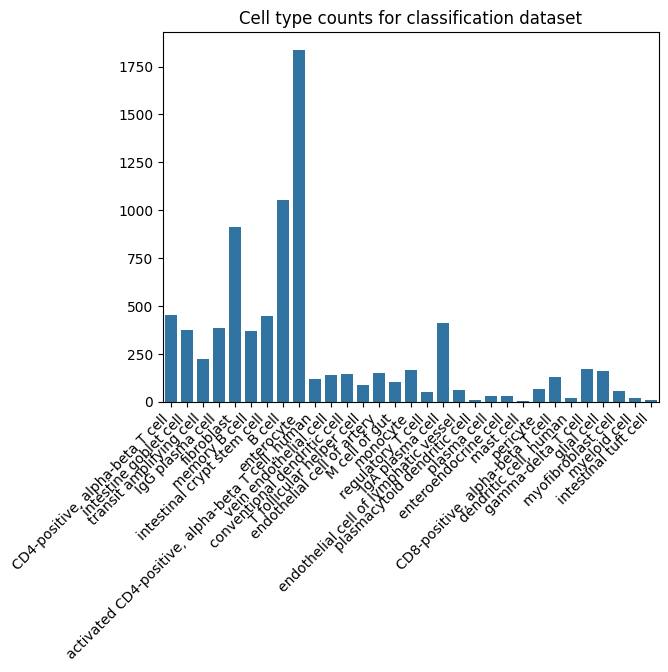

In [19]:
# Now we look at our dataset, how is the distribution of cell counts? Its clear that certain celltypes dominate the dataset, this is good to keep in mind when investigating models. 
#  we expect the macro averages and F1-score to be the most reliable metrics for overall performance.
from collections import Counter
import seaborn as sb

labels = infer_metadata['cell_type'].values
label_counts = Counter(labels)

ax = sb.barplot(x=label_counts.keys(), y=label_counts.values())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title("Cell type counts for classification dataset")

In [20]:
# Now we assign integer labels to each of our strings. These do not need to be transformed into one-hot vectors as Random Forest is non-parametric.
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(labels)
print(integer_labels)  

[ 1  1 19 ... 17 14 14]


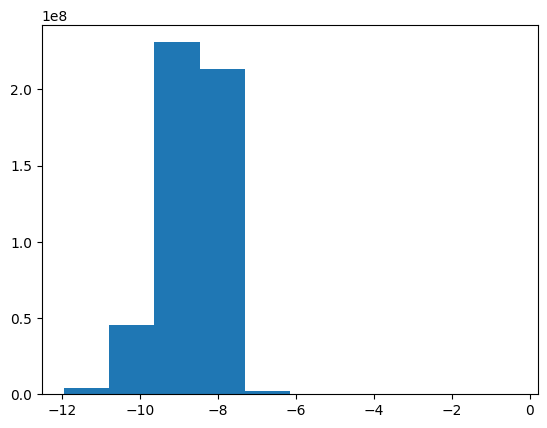

In [21]:
# Distribution of log transforms, looks decent.
from matplotlib import pyplot
pyplot.hist(logp1_Xs.flatten());

In [22]:
def plot_cm(cm, labels=label_encoder.classes_):
    '''
    Helper function for visualizing accuracy across labels.
    '''
    from matplotlib.colors import BoundaryNorm, ListedColormap

    # Example confusion matrix (replace with your actual data)
    conf_matrix = np.random.rand(31, 31)

    # Define the bins and the color map
    #bounds = np.arange(0.0, 1.1, 0.1)
    #cmap = ListedColormap(sb.color_palette("RdYlBu_r", len(bounds) - 1))
    #norm = BoundaryNorm(boundaries=bounds, ncolors=len(bounds) - 1, clip=True)

    #_ = sb.heatmap(cm / cm.sum(axis=0),cmap=cmap, norm=norm, cbar_kws={"ticks": bounds}, linewidths=0.5, linecolor='black', xticklabels=labels, yticklabels=labels)
    _ = sb.heatmap(cm / cm.sum(axis=0), cmap=sb.color_palette("Blues", as_cmap=True), vmin=0, vmax=1, linewidth=0.1, linecolor='lightgrey', xticklabels=labels, yticklabels=labels)
    pyplot.xticks(rotation=45, ha='right')
    _ = pyplot.yticks(rotation=0)

## Execute benchmarks
Finally we execute our benchmarks, and collect results and confusion matrix. You can see in the figures below, we plot the performance by cell type for each model (confusion matrix heatmap). Perhaps unsurprisingly, we see that the most frequent cell type (enterocyte) has the highest accuracy across all models. This suggests bias in the model due to unbalanced data, however, further investigation is beyond the scope of this tutorial. Furthermore, we see continually improved performance as we move through the models, from baselines, to our provided pretrained model.

Perhaps most interesting is the 106M parameter model, which clearly outperforms all other models by all metrics, but especially by F1-score. This suggests that training larger models based on geneformer perform well, and that more work may be done.

In [23]:
logp1_results, logp1_cm = run_benchmark(logp1_Xs, integer_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Cross-validation metrics:
accuracy: 0.773 (+/- 0.034)
precision: 0.630 (+/- 0.042)
recall: 0.550 (+/- 0.022)
f1_score: 0.562 (+/- 0.027)
roc_auc: 0.973 (+/- 0.008)


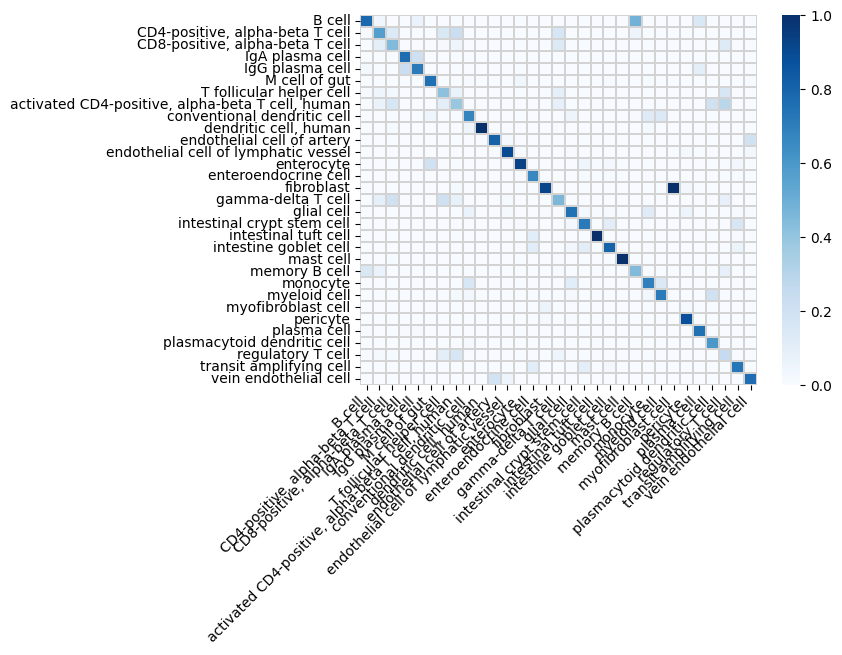

In [24]:
plot_cm(logp1_cm)

In [25]:
results_10m_random, cm_10m_random = run_benchmark(infer_Xs_10m_random, integer_labels, use_pca=False)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Cross-validation metrics:
accuracy: 0.402 (+/- 0.012)
precision: 0.139 (+/- 0.025)
recall: 0.093 (+/- 0.005)
f1_score: 0.080 (+/- 0.005)
roc_auc: 0.741 (+/- 0.013)


/tmp/ipykernel_703689/3742577664.py:16: RuntimeWarning: invalid value encountered in divide
  _ = sb.heatmap(cm / cm.sum(axis=0), cmap=sb.color_palette("Blues", as_cmap=True), vmin=0, vmax=1, linewidth=0.1, linecolor='lightgrey', xticklabels=labels, yticklabels=labels)


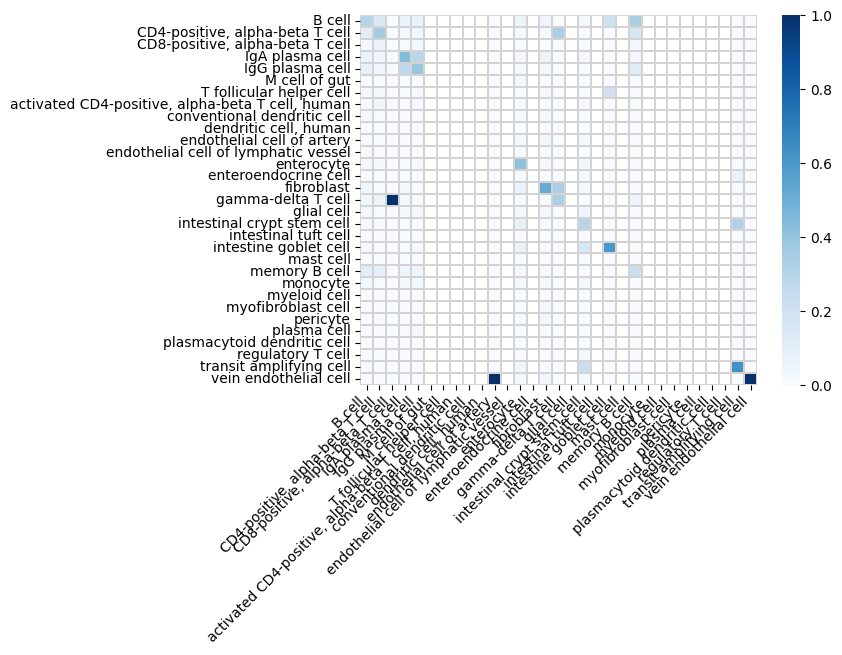

In [26]:
plot_cm(cm_10m_random)

In [27]:
results_10m, cm_10m = run_benchmark(infer_Xs_10m, integer_labels, use_pca=False)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Cross-validation metrics:
accuracy: 0.838 (+/- 0.021)
precision: 0.806 (+/- 0.032)
recall: 0.690 (+/- 0.019)
f1_score: 0.715 (+/- 0.018)
roc_auc: 0.988 (+/- 0.003)


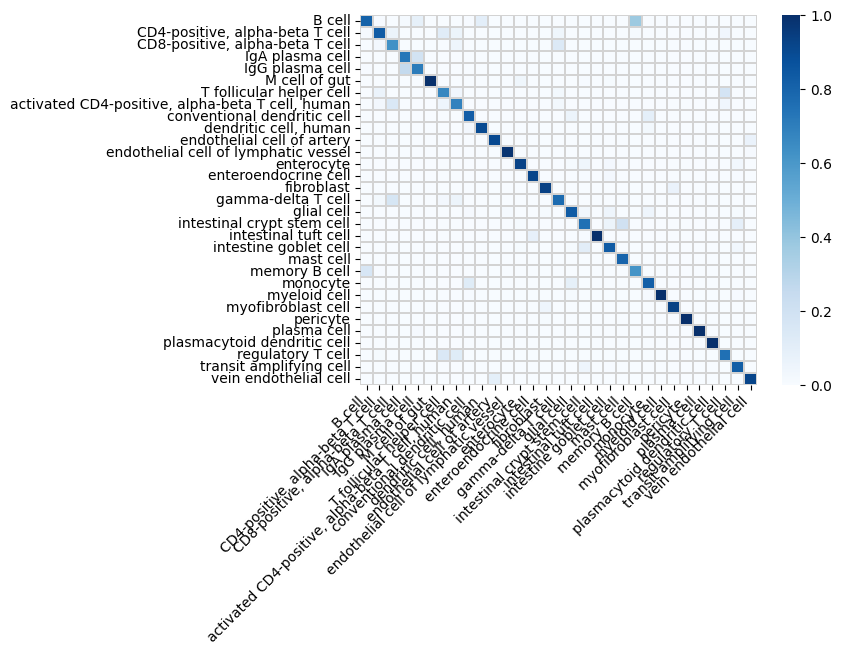

In [28]:
plot_cm(cm_10m)

In [29]:
results_10m_bnmo2, cm_10m_bnmo2 = run_benchmark(infer_Xs_10m_bnmo2, integer_labels, use_pca=False)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Cross-validation metrics:
accuracy: 0.838 (+/- 0.022)
precision: 0.804 (+/- 0.039)
recall: 0.688 (+/- 0.026)
f1_score: 0.713 (+/- 0.026)
roc_auc: 0.985 (+/- 0.014)


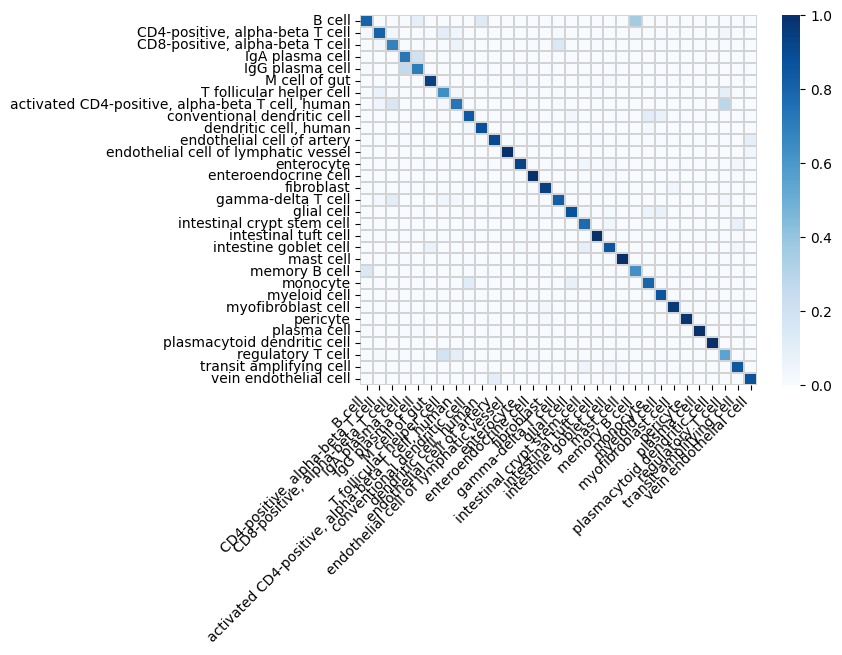

In [30]:
plot_cm(cm_10m_bnmo2)

In [31]:
results_106M, cm_106M = run_benchmark(infer_Xs_106m, integer_labels, use_pca=False)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cross-validation metrics:
accuracy: 0.905 (+/- 0.017)
precision: 0.912 (+/- 0.022)
recall: 0.820 (+/- 0.015)
f1_score: 0.844 (+/- 0.017)
roc_auc: 0.993 (+/- 0.007)


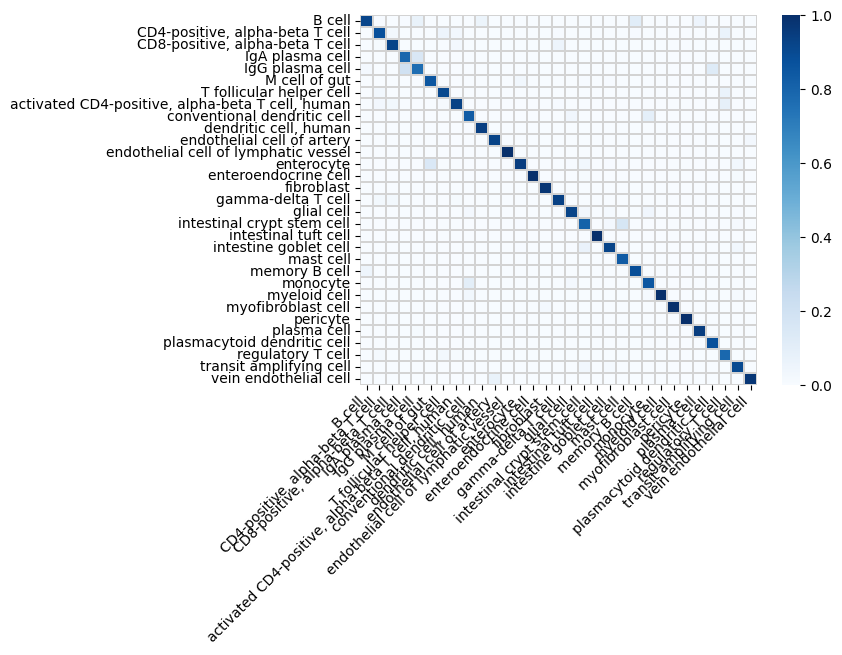

In [32]:
plot_cm(cm_106M)

/tmp/ipykernel_703689/805283967.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x='model', y='f1_score_mean', data=df, capsize=0.2, palette='viridis', ax=ax)
/tmp/ipykernel_703689/805283967.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x='model', y='accuracy_mean', data=df, ax=ax, capsize=0.2, palette='viridis')


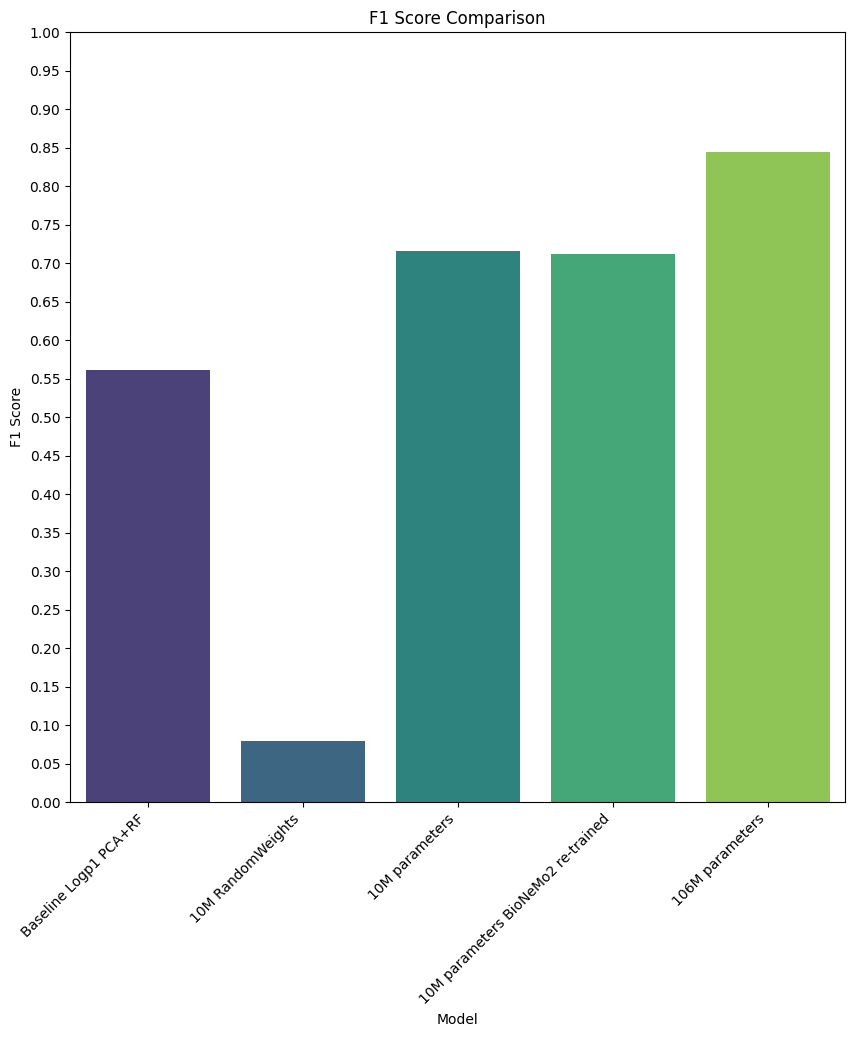

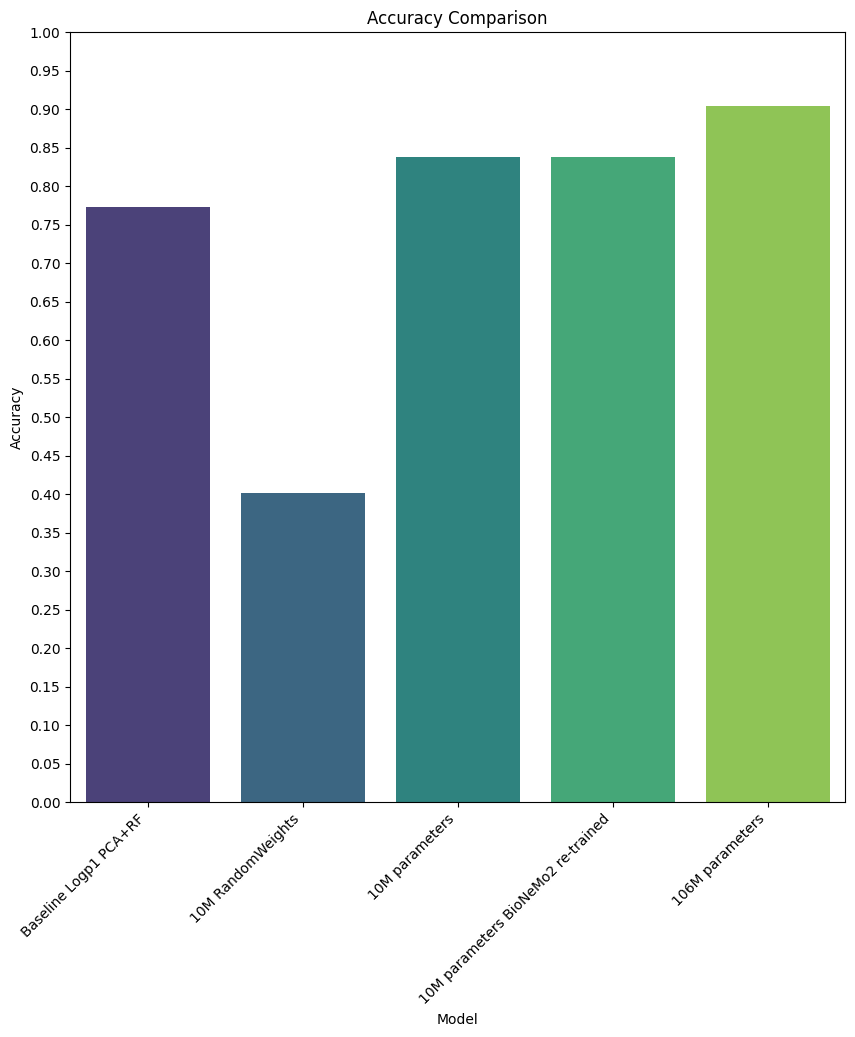

In [33]:
data = {
    'model': [
        'Baseline Logp1 PCA+RF', 
        '10M RandomWeights',
        '10M parameters', 
        '10M parameters BioNeMo2 re-trained',
        '106M parameters'],
    'f1_score_mean': [
        logp1_results['test_f1_score'][0],
        results_10m_random['test_f1_score'][0],
        results_10m['test_f1_score'][0],
        results_10m_bnmo2['test_f1_score'][0],
        results_106M['test_f1_score'][0]
    ],
    'f1_score_std': [
        logp1_results['test_f1_score'][1],
        results_10m_random['test_f1_score'][1],
        results_10m['test_f1_score'][1],
        results_10m_bnmo2['test_f1_score'][1],
        results_106M['test_f1_score'][1]
    ],
    'accuracy_mean': [
        logp1_results['test_accuracy'][0],
        results_10m_random['test_accuracy'][0],
        results_10m['test_accuracy'][0],
        results_10m_bnmo2['test_accuracy'][0],
        results_106M['test_accuracy'][0]
    ],
    'accuracy_std': [
        logp1_results['test_accuracy'][1],
        results_10m_random['test_accuracy'][1],
        results_10m['test_accuracy'][1],
        results_10m_bnmo2['test_accuracy'][1],
        results_106M['test_accuracy'][1]
    ]
}

df = pd.DataFrame(data)

fig, ax = pyplot.subplots(figsize=(10, 10))
# F1 Score plot
sb.barplot(x='model', y='f1_score_mean', data=df, capsize=0.2, palette='viridis', ax=ax)
ax.set_title('F1 Score Comparison')
ax.set_xlabel('Model')
ax.set_ylabel('F1 Score')
ax.set_yticks(np.arange(.0, 1.05, .05))
ax.set_ylim(.0, 1.0)
pyplot.xticks(rotation=45, ha='right')
pyplot.savefig("F1-score-models.png")

# Accuracy plot
fig, ax = pyplot.subplots(figsize=(10, 10))
sb.barplot(x='model', y='accuracy_mean', data=df, ax=ax, capsize=0.2, palette='viridis')
ax.set_title('Accuracy Comparison')
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_yticks(np.arange(.0, 1.05, .05))
ax.set_ylim(.0, 1.0)
pyplot.xticks(rotation=45, ha='right')
pyplot.savefig("average-accuracy-models.png")